In [18]:
# 필요한 패키지 설치
%pip install transformers torch scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 데이터 로드 관련
import pandas as pd
import glob
import os
from tqdm import tqdm

# KC-BERT 감성 분류 예측 관련
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

# 경고 무시
import warnings
warnings.filterwarnings("ignore")

c:\Users\smhrd\AppData\Local\Programs\Orange\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. data 폴더 내 모든 CSV 파일 로드 및 정보 확인
- df_list = 각 CSV 파일을 DataFrame으로 읽어 생성한 리스트
- df_list 길이 = data 폴더 내 CSV 파일 수 (7)

In [3]:
# data 폴더 안의 모든 CSV 파일 경로 리스트
csv_files = glob.glob(os.path.join('./data', '*.csv'))

# 각 파일을 DataFrame으로 읽고 리스트에 저장
df_list = [pd.read_csv(file) for file in csv_files]
df_list

[          id       brand                                          name  \
 0     607298  비에스큐티바이클래시                             375 웰던 더비 구두 루시블랙   
 1    4062428        닥터마틴                      1461 3홀 모노 블랙 / 14345001   
 2    1815709       로맨틱무브                      베이스먼트 더비 R24M042 (BX 블랙)   
 3    1021359    마이애미프로젝트                      0891 코즈웨이 베이직 페니 로퍼 밴타블랙   
 4    2433538    피렌체 아뜨리에  SECOND.A 볼륨 라운드토 5CM 더비슈즈 2NDF2700GB [BLACK]   
 ..       ...         ...                                           ...   
 114  3429450          슈펜                     토캡 버클 메리제인 1.0 HPWWFD4802   
 115  1838050         바토즈                                         Cro 1   
 116  2085612        프리플라                         ljh3003 flat _ 2color   
 117  4026542    무신사 스탠다드                            키높이 플레인 더비 슈즈 [블랙]   
 118  3082249   커스텀에이드 우먼                 3/5/7cm 포인티드토 통굽힐 라비나(CW0002)   
 
     like_count  rating discount     price gender  \
 0         2.6만     4.7       9%   53,600원   

In [4]:
for file, df in zip(csv_files, df_list):
    print(f"파일명: {os.path.basename(file)} 데이터 정보 확인")
    print(df.info())
    print("-" * 60)

파일명: product_list_구두_count.csv 데이터 정보 확인
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 119 non-null    int64  
 1   brand              119 non-null    object 
 2   name               119 non-null    object 
 3   like_count         119 non-null    object 
 4   rating             119 non-null    float64
 5   discount           102 non-null    object 
 6   price              119 non-null    object 
 7   gender             119 non-null    object 
 8   link               119 non-null    object 
 9   image              119 non-null    object 
 10  category1          119 non-null    object 
 11  category2          119 non-null    object 
 12  category3          119 non-null    object 
 13  detailed_image_1   118 non-null    object 
 14  detailed_image_2   116 non-null    object 
 15  detailed_image_3   110 non-null  

In [ ]:
# 사전학습된 KC-BERT 모델 (긍정/부정 이진분류)
MODEL_NAME = "beomi/kcbert-base"

# 데이터 로드
review_data = pd.read_csv('./data/tagged_review_data_전체신발.csv', encoding='utf-8')

# 1. 모델 및 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.eval()  # 평가 모드로 설정

# 2. 데이터 준비
reviews = review_data['review'].tolist()

# 3. 감성 분석 수행
labels = []
scores = []

for text in tqdm(reviews, desc="분석 중"):
    # 텍스트 인코딩
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 확률 계산 (softmax) 
    probs = softmax(outputs.logits, dim=1)
    score = probs[0][1].item()  # 긍정 클래스 확률
    label = "1" if score >= 0.5 else "0"
    
    labels.append(label)
    scores.append(round(score, 4))  # 감정 점수 (긍정 확률)

# 4. 결과 추가
review_data['label'] = labels # -> 생략가능 추후 학습 시 drop 예정
review_data['score'] = scores

# 5. 저장 또는 출력
review_data.to_csv("./data/감정분석_결과.csv", index=False)
print(review_data[['review', 'sentiment_label', 'sentiment_score']].head())

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm.auto import tqdm

# 모델명
MODEL_NAME = "beomi/KcELECTRA-base"

# 1. 모델 및 토크나이저 로드 (분류용 모델로!)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.eval()

# 2. 데이터 로드
review_data = pd.read_csv('./data/tagged_review_data_전체신발.csv', encoding='utf-8')
reviews = review_data['review'].tolist()

# 3. 감정 분석
labels = []
scores = []

for text in tqdm(reviews, desc="분석 중"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=300)
        
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = softmax(outputs.logits, dim=1)
    score = probs[0][1].item()  # 긍정 확률
    label = int(score >= 0.5)   # 0 or 1
    
    labels.append(label)
    scores.append(round(score, 4))

# 4. 결과 저장
review_data['sentiment_label'] = labels
review_data['sentiment_score'] = scores

# 5. 저장
review_data.to_csv("./data/감정분석_결과_KcELECTRA.csv", index=False)
print(review_data[['review', 'sentiment_label', 'sentiment_score']].head())


In [25]:
review_data.head()

,id,gender,rating,review,likes,tagged_review,감정_라벨,감정_점수
0,607298,M,4,패션 고자입니다. 대충 참고만..해주세요. 청바지보다는 슬랙스에 더 나은듯,55,"['패션', '고자', '대충', '참고', '해주다', '청바지', '슬랙스', ...",긍정,0.5316
1,607298,M,1,처음 주문 했을때 바람빠지는소리가 오른쪽 신발에서 너무 많이나서 겨환이나 환불을 하...,46,"['처음', '주문', '바람', '빠지다', '소리', '오른쪽', '신발', '...",긍정,0.6028
2,607298,M,5,가성비 좋아요. 265시는데 265. 콱 끈하면 돼네요,44,"['가성', '비', '좋다', '콱', '끈', '돼다']",긍정,0.5855
3,607298,M,4,정장에 신으려고 샀는데 클래식한 느낌이 나서 마음에 드네요!,38,"['정장', '신다', '사다', '클래식', '느낌', '나서다', '마음', '...",긍정,0.6053
4,607298,M,4,평소에 265신는데 270으로 샀습니다. 확실히 사이즈가 크긴 하네요 아쉬워요.,36,"['평소', '신다', '사다', '확실하다', '사이즈', '크다', '아쉽다']",긍정,0.5527


In [26]:
review_data['감정_라벨'].value_counts()

감정_라벨
긍정    19985
부정       15
Name: count, dtype: int64

In [27]:
review_data['감정_점수'].describe()

count    20000.000000
mean         0.594572
std          0.030718
min          0.458900
25%          0.573900
50%          0.593600
75%          0.614400
max          0.729900
Name: 감정_점수, dtype: float64

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import sigmoid
from tqdm.auto import tqdm

# 1. 모델 로드
model_name = "nlpmhp/korean_sentiment_classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# 2. 데이터 불러오기
df = pd.read_csv("./data/tagged_review_data_전체신발.csv")
reviews = df['review'].tolist()

# 3. 감정 분석
labels = []
scores = []

for text in tqdm(reviews, desc="감정 분류 중"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=300)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = softmax(outputs.logits, dim=1)
    score = round(probs[0][1].item(), 4)       # 긍정 점수
    label = int(torch.argmax(probs))           # 0 or 1
    labels.append(label)
    scores.append(score)

# 4. 결과 저장
df["sentiment_label"] = labels
df["sentiment_score"] = scores
df.to_csv("./data/감정분석결과_nlpmhp.csv", index=False)

print("감정 분류 완료! → 'sentiment_label', 'sentiment_score' 컬럼 추가됨")


감정 분류 중: 100%|██████████| 315753/315753 [3:34:03<00:00, 24.58it/s]  


✅ 감정 분류 완료! → 'sentiment_label', 'sentiment_score' 컬럼 추가됨


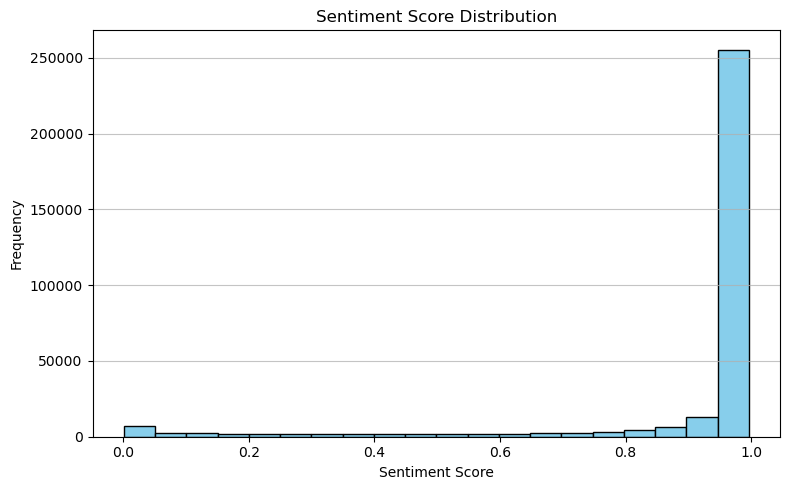

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "./data/감정분석결과_nlpmhp.csv"
df = pd.read_csv(file_path)

# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm.auto import tqdm

# 1. 모델 로드
model_name = "nlp04/korean_sentiment_analysis_kcelectra"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# 2. 데이터 불러오기
df = pd.read_csv("./data/review_data_전체신발.csv")
reviews = df['review'].tolist()

# 3. 감정 분석
labels = []
scores = []

for text in tqdm(reviews, desc="감정 분류 중"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=300)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = softmax(outputs.logits, dim=1)
    score = round(probs[0][1].item(), 2)       # 긍정 확률 = 감성 점수
    label = int(torch.argmax(probs))           # 0=부정, 1=긍정
    labels.append(label)
    scores.append(score)

# 4. 결과 저장
df["sentiment_label"] = labels
df["sentiment_score"] = scores
df.to_csv("./data/감정분석결과_nlp04.csv", index=False)

print("🎉 감정 분류 완료! → 'sentiment_label', 'sentiment_score' 컬럼 추가됨")


감정 분류 중: 100%|██████████| 315753/315753 [3:14:28<00:00, 27.06it/s]  


🎉 감정 분류 완료! → 'sentiment_label', 'sentiment_score' 컬럼 추가됨


In [27]:
df_KcBert= pd.read_csv("./data/감정분석결과_KcBert.csv")
df_KcBert['label'].value_counts()

label
0    195782
1    119971
Name: count, dtype: int64

In [26]:
df_KcBert['score'].describe()

count    315753.000000
mean          0.478115
std           0.069909
min           0.284000
25%           0.421500
50%           0.471000
75%           0.531900
max           0.772700
Name: score, dtype: float64

In [6]:
df_npl04= pd.read_csv("./data/감정분석결과_nlp04.csv")
df_npl04['sentiment_label'].value_counts()

sentiment_label
0     212521
7      26012
1      25079
6      16422
4      15247
5      12248
9       6906
10       729
2        542
3         40
8          7
Name: count, dtype: int64

In [5]:
df_npl04['sentiment_score'].describe()

count    315753.000000
mean          0.166086
std           0.134188
min           0.000000
25%           0.070000
50%           0.140000
75%           0.240000
max           0.830000
Name: sentiment_score, dtype: float64

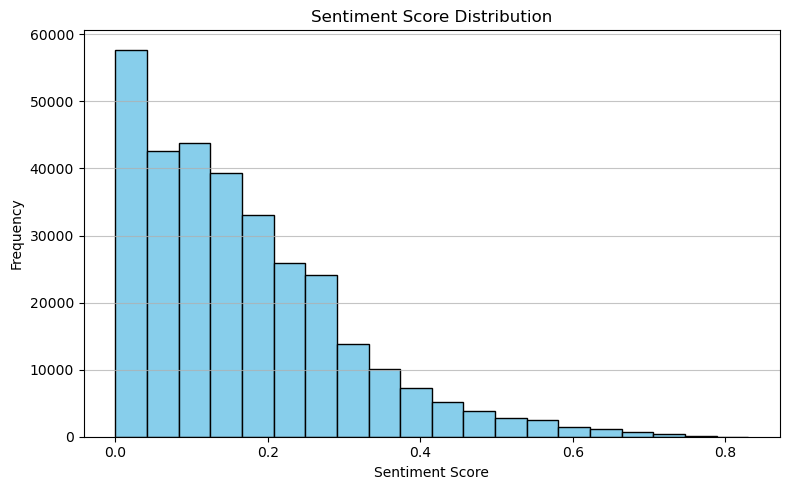

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "./data/감정분석결과_nlp04.csv"
df = pd.read_csv(file_path)

# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [ ]:
df_nlpmhp= pd.read_csv("./data/감정분석결과_nlpmhp.csv")
df_nlpmhp['sentiment_score'].describe()

count    315753.000000
mean          0.905762
std           0.221423
min           0.001000
25%           0.969400
50%           0.986900
75%           0.991400
max           0.996200
Name: sentiment_score, dtype: float64

In [29]:
df_nlpmhp['sentiment_label'].value_counts()

sentiment_label
1    292455
0     23298
Name: count, dtype: int64

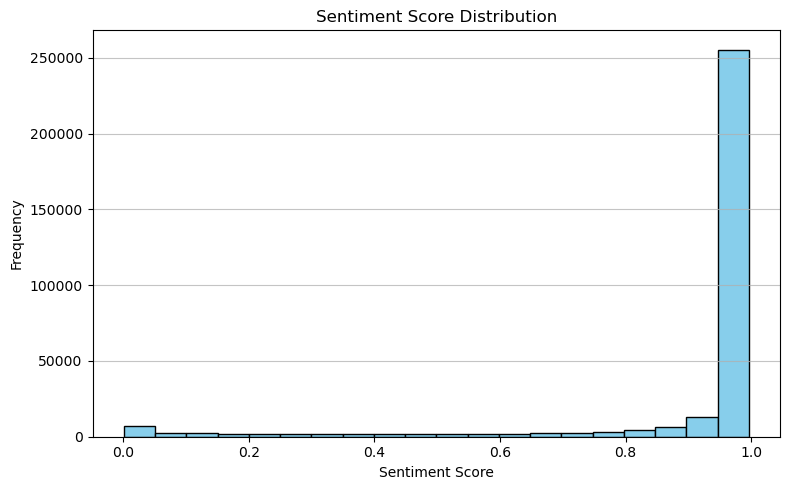

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "./data/감정분석결과_nlpmhp.csv"
df = pd.read_csv(file_path)

# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

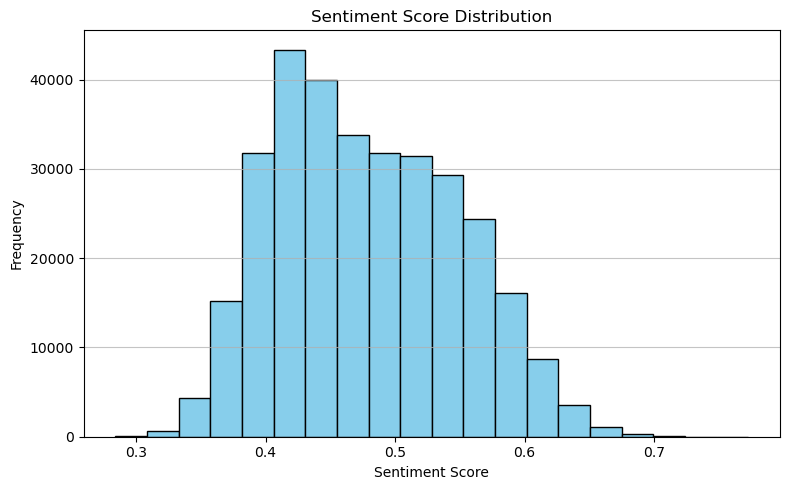

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "./data/감정분석결과_KcBert.csv"
df = pd.read_csv(file_path)

# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(df['score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [38]:
# 1. TF-IDF 점수를 딕셔너리로 변환
import pandas as pd
import numpy as np

tfidf_df = pd.read_csv('./data/review_tf-idf.csv')
tagged_df = pd.read_csv('./data/tagged_review_data_전체신발.csv')

tfidf_dict = dict(zip(tfidf_df['word'], tfidf_df['tf-idf']))

# 2. 리뷰별 감성 점수 계산 함수 정의
def calculate_sentiment_score(tagged_text):
    try:
        words = tagged_text.strip("[]").replace("'", "").split(", ")
        tfidf_scores = [tfidf_dict[word] for word in words if word in tfidf_dict]
        if tfidf_scores:
            return round(sum(tfidf_scores) / len(tfidf_scores), 4)
        else:
            return 0.0
    except:
        return 0.0

# 3. 각 리뷰에 대해 감성 점수 계산
tagged_df['sentiment_score'] = tagged_df['tagged_review'].apply(calculate_sentiment_score)

# 4. 결과 확인
tagged_df[['review', 'tagged_review', 'sentiment_score']].head()


,review,tagged_review,sentiment_score
0,패션 고자입니다. 대충 참고만..해주세요. 청바지보다는 슬랙스에 더 나은듯,"['패션', '고자', '대충', '참고', '해주다', '청바지', '슬랙스', ...",0.0018
1,처음 주문 했을때 바람빠지는소리가 오른쪽 신발에서 너무 많이나서 겨환이나 환불을 하...,"['처음', '주문', '바람', '빠지다', '소리', '오른쪽', '신발', '...",0.0114
2,가성비 좋아요. 265시는데 265. 콱 끈하면 돼네요,"['가성', '비', '좋다', '콱', '끈', '돼다']",0.0290
3,정장에 신으려고 샀는데 클래식한 느낌이 나서 마음에 드네요!,"['정장', '신다', '사다', '클래식', '느낌', '나서다', '마음', '...",0.0141
4,평소에 265신는데 270으로 샀습니다. 확실히 사이즈가 크긴 하네요 아쉬워요.,"['평소', '신다', '사다', '확실하다', '사이즈', '크다', '아쉽다']",0.0232


In [39]:
tagged_df['sentiment_score'].describe()

count    315753.000000
mean          0.019732
std           0.008287
min           0.000000
25%           0.014000
50%           0.018900
75%           0.024600
max           0.072400
Name: sentiment_score, dtype: float64

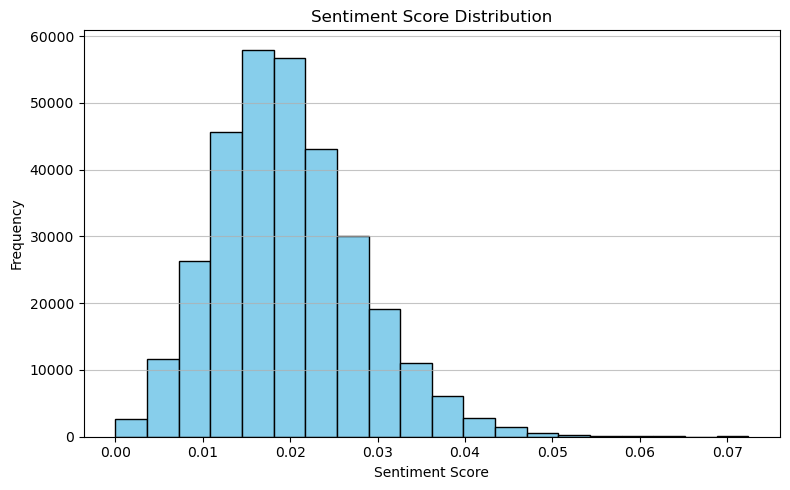

In [40]:
import pandas as pd
import matplotlib.pyplot as plt


# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(tagged_df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

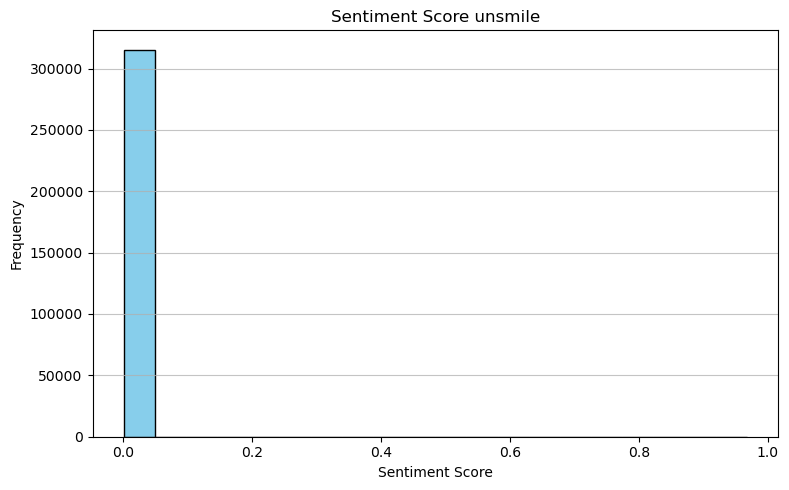

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "./data/감정분석_결과_unsmile.csv"
df = pd.read_csv(file_path)

# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(df['unsmile_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score unsmile')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

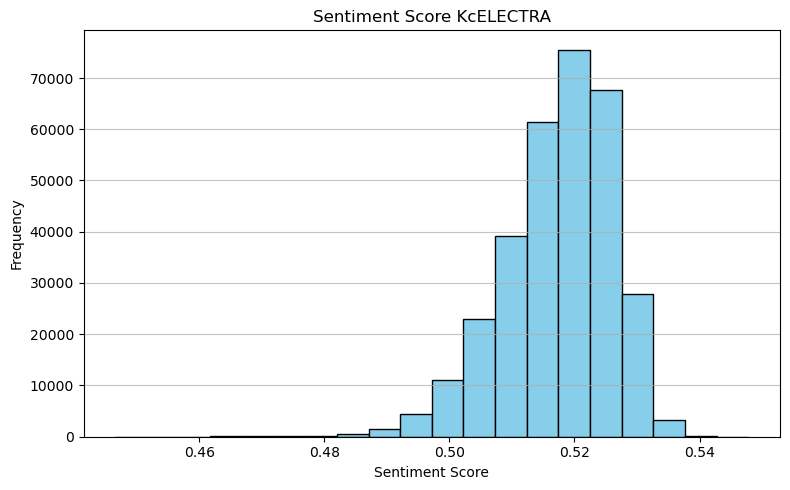

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "./data/감정분석_결과_KcELECTRA.csv"
df = pd.read_csv(file_path)

# sentiment_score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score KcELECTRA')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

### kc-bert(min-max, tanh)

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np

# 1. 데이터 불러오기
df = pd.read_csv("./data/review_data_전체신발.csv")
reviews = df['review'].astype(str).tolist()

# 2. 모델 로드 (KC-BERT for regression)
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class KcBERTForRegression(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0]
        score = self.regressor(cls_output).squeeze(-1)
        return score

# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KcBERTForRegression(model_name).to(device)
model.eval()

# 3. 감성 점수 예측
scores = []

with torch.no_grad():
    for text in tqdm(reviews, desc="감성 점수 예측 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        output = model(**inputs)
        score = output.item()
        scores.append(score)

# 4. Min-Max Scaling → tanh → tanh(2x + 0.3)
score_series = pd.Series(scores)
min_val = score_series.min()
max_val = score_series.max()
minmax_scaled = (score_series - min_val) / (max_val - min_val)
mmt = np.tanh(minmax_scaled)
Sentiment_Score = np.tanh(2 * mmt + 0.3)

# 5. 결과 추가
df['Sentiment_score'] = Sentiment_Score
df['Sentiment_label'] = (Sentiment_Score >= 0.5).astype(int)  # 0 or 1 라벨

# 6. 저장
output_path = "./data/Review_data_KcBERT.csv"
df.to_csv(output_path, index=False)

감성 점수 예측 중:   1%|          | 1723/315753 [01:10<3:32:31, 24.63it/s]

In [2]:
from transformers import pipeline

pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")

result = pipe("The shoes are wide and comfortable. I’ll enjoy wearing them. Wishing you lots of sales!")
print(result)

Device set to use cpu


[{'label': 'Positive', 'score': 0.43775829672813416}]


In [15]:

from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True
)

text = """The soles came off just a month after I bought them, so I ended up throwing them away… I'm really disappointed. Even though I got them at a low price, I didn’t wear them that many times in a month — how does it make sense for the soles to fall apart like that? When they were first delivered, they even sent me mismatched sizes — one was 280mm and the other 260mm. I had to go through several days of waiting just to finally get a proper pair in 280mm. And now, after barely wearing them, this happens. One of the photos shows the mismatched pair from the initial delivery, and the other shows how destroyed they are after just one month."""

result = pipe(text)
print(result)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
c:\Users\smhrd\AppData\Local\Programs\Orange\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1

[[{'label': 'negative', 'score': 0.8963890671730042}, {'label': 'neutral', 'score': 0.09599921852350235}, {'label': 'positive', 'score': 0.007611727342009544}]]


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

# 진짜 처음사보는데 다음에는 절대 안사야지 너무 딱딱하네 [{'label': 'negative', 'score': 0.4293977618217468}]
# 발볼도 넓고 편하네요 잘 신겠습니다 많이 파세요  [{'label': 'positive', 'score': 0.9260769486427307}]
# 발은 아프지만 이쁘긴 진짜 이뻐요 입문용 개이득 [{'label': 'positive', 'score': 0.7507539391517639}]
# 정사이즈 250, 운동화 255 신는데 260이 딱 편해요. 250 처음에 구매했다가 발아퍼서 260 교환했는데 너무너무 잘 맞습니다.  [{'label': 'positive', 'score': 0.6997151374816895}]
# 산지 한달만에 밑창 뜯어져서 갖다 버렸어요 .. 실망이 좀 큽니다 싸게샀다해도 한달동안 몇 번 신지도 않았는데 밑창 뜯기는 게 말이되나요? 처음배송올때도 280하나랑 260하나 짝재기 보내줘서 반품시키로 몇날몇일 기다려 겨우 양쪽 다 280 세트 받았는데 얼마 신지도 않았는데 저런 꼴 나네요. 사진 하나는 처음 배송 때 짝짝이 배송 온 사진이고 다른 사진하나는 한달만에 씹창난 사진입니다. [{'label': 'negative', 'score': 0.7566335797309875}]

result = pipe("The soles came off just a month after I bought them, so I ended up throwing them away… I'm really disappointed. Even though I got them at a low price, I didn’t wear them that many times in a month — how does it make sense for the soles to fall apart like that? When they were first delivered, they even sent me mismatched sizes — one was 280mm and the other 260mm. I had to go through several days of waiting just to finally get a proper pair in 280mm. And now, after barely wearing them, this happens. One of the photos shows the mismatched pair from the initial delivery, and the other shows how destroyed they are after just one month.")
print(result)

Device set to use cpu


[{'label': 'negative', 'score': 0.7566335797309875}]


In [19]:
%pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [15]:
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig, BertPreTrainedModel, get_scheduler
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# 1. 감성사전 불러오기 및 딕셔너리로 변환
with open("./data/SentiWord_info.json", "r", encoding="utf-8") as f:
    senti_list = json.load(f)

senti_dict = {
    item["word"]: float(item["polarity"])
    for item in senti_list
    if "word" in item and "polarity" in item
}

# 감성 점수 계산 함수
def get_sentiment_score(text):
    scores = []
    for word in text.split():
        score = senti_dict.get(word)
        if score is not None:
            scores.append(score)
    return np.mean(scores) if scores else 0.0

# 2. 리뷰 데이터 로드 및 감성 점수 매핑
df = pd.read_csv("./data/review_data_전체신발.csv")
df["score"] = df["review"].astype(str).apply(get_sentiment_score)

# 3. Dataset 정의
class ReviewDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, max_len=128):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "score": torch.tensor(self.scores[idx], dtype=torch.float),
        }

# 4. KC-BERT 회귀 모델 정의
class BertForRegression(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.regressor = nn.Linear(config.hidden_size, 1)
        self.init_weights()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        score = self.regressor(pooled_output)
        return score.squeeze(-1)

# 5. 모델 및 토크나이저 로드
model_name = "beomi/kcbert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)
model = BertForRegression.from_pretrained(model_name, config=config)

# 6. 학습 세팅
train_dataset = ReviewDataset(df["review"].tolist(), df["score"].tolist(), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 30
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 7. 학습 루프 (Epoch = 30)
for epoch in range(30):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/30"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["score"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.MSELoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# 8. 모델 저장
model.save_pretrained("./kcbert_regression_model")
tokenizer.save_pretrained("./kcbert_regression_model")


Some weights of BertForRegression were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/30:   8%|▊         | 1603/19735 [1:41:36<19:09:20,  3.80s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from transformers import BertTokenizer, BertConfig
from torch import nn
from transformers import BertModel

# 1. 회귀용 KC-BERT 모델 정의 (학습 때와 똑같이)
class BertForRegression(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        score = self.regressor(pooled_output)
        return score.squeeze(-1)

# 2. 모델 및 토크나이저 불러오기
model_path = "./kcbert_regression_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForRegression(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 3. 예측 함수 정의
def predict_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        output = model(**inputs)
        score = output.item()
    return round(score, 4)

# 4. 테스트 예시
test_review = "배송이 빠르고 너무 만족스러워요!"
predicted_score = predict_sentiment_score(test_review)
print(f"감성 점수: {predicted_score}")
